# Fake Job Listing Detection

In [15]:
!pip install wordcloud

You should consider upgrading via the '/home/oem/anaconda3/bin/python -m pip install --upgrade pip' command.


In [16]:
!pip install -U spacy

You should consider upgrading via the '/home/oem/anaconda3/bin/python -m pip install --upgrade pip' command.


In [17]:
import re 
import string 
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report, confusion_matrix
from wordcloud import WordCloud
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import scikitplot as skplt



In [18]:
df=pd.read_csv('fake_job_postings.csv')

In [19]:
df.tail(50)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
17830,17831,Payroll Clerk,"US, NY, New York",NaN,NaN,NaN,JOB DESCRIPTIONWe are seeking a full time payr...,JOB REQUIREMENTS• High school diploma or eq...,We offer a competitive salary and benefits pac...,0,0,0,Full-time,NaN,NaN,Apparel & Fashion,Accounting/Auditing,1
17831,17832,Furniture mover,"US, IL, Chicago",NaN,NaN,Anthony Warren is a Marketing and Advertising ...,earn $500 to $1000 a week as a mover. Must ha...,Good liftflexibile schedulegeat attitude,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,1
17832,17833,Sales Controller / Assistant,"GB, , London",NaN,NaN,NaN,"Based in the heart of the City, this exception...",You will have previously been employed in a sa...,Excellent Salaries Company Benefit PackagesInt...,0,1,0,Full-time,Not Applicable,Bachelor's Degree,Retail,Sales,0
17833,17834,Web Designer,"UA, ,",NaN,NaN,NaN,We’re looking for a web designer with a passio...,What skills are we looking for?English-speakin...,NaN,1,1,1,NaN,NaN,NaN,NaN,NaN,0
17834,17835,Enterprise Account Executive US,"US, CA, San Francisco",Sales,NaN,Engagor is a venture backed startup founded in...,Engagor is looking for an Enterprise Account E...,Experience within a sales team that produces a...,Competitive base salary + uncapped quarterly c...,0,1,1,Full-time,Associate,Bachelor's Degree,Internet,Sales,0
17835,17836,Sr.Business Intelligence Technical Architect,"US, CA, Silicon Valley/San Jose - Santa Clara",Information Technology,NaN,Roland &amp; Associates is a Corporate Recruit...,Experience : 10 - 20 YearsImplementation exper...,NaN,NaN,0,1,1,NaN,NaN,NaN,NaN,NaN,0
17836,17837,Licensed Practical Nurse (LPN)- Private Duty,"US, MO, Independence",Nursing,NaN,Phoenix Home Care came to be as a result of ou...,If you want to apply your nursing skills in a ...,Reliable transportation and working telephone ...,Phoenix understands that we would not be succe...,0,1,0,NaN,NaN,NaN,NaN,NaN,0
17837,17838,Senior Backend Developers,NaN,NaN,NaN,Gelato Group is a SaaS company. We've develope...,Following our global expansion we are seeking ...,A minimum of B.S. degree in Information Techno...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
17838,17839,Senior Sales Executive - Simple Relevance,"US, IL, Chicago",Simple Relevance,NaN,The story of the Great Chicago Fire of 1871 is...,OVERVIEW1871 IS COMMITTED TO HELPING OUR ENTRE...,- Proven track record of closing Fortune 500 c...,Simple Relevance offers a very competitive bas...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Information Technology and Services,Sales,0
17839,17840,SAS Grid Developer,"US, NJ, Berkeley Heights",NaN,NaN,NaN,Job Title: SAS Grid DeveloperDuration: 06+ mon...,Mandatory Technical /Functional Skills:• IT ex...,NaN,0,0,0,Contract,Mid-Senior level,NaN,NaN,NaN,0


In [20]:
df.shape

(17880, 18)

In [21]:
#check null values

df.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [22]:
columns=['job_id', 'telecommuting', 'has_company_logo', 'has_questions', 'salary_range', 'employment_type']
for col in columns:
    del df[col]

In [23]:
df.head()

,title,location,department,company_profile,description,requirements,benefits,required_experience,required_education,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,Internship,NaN,NaN,Marketing,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,NaN,NaN,NaN,NaN,0
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,Bill Review Manager,"US, FL, Fort Worth",NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [24]:
df.fillna('',inplace=True)

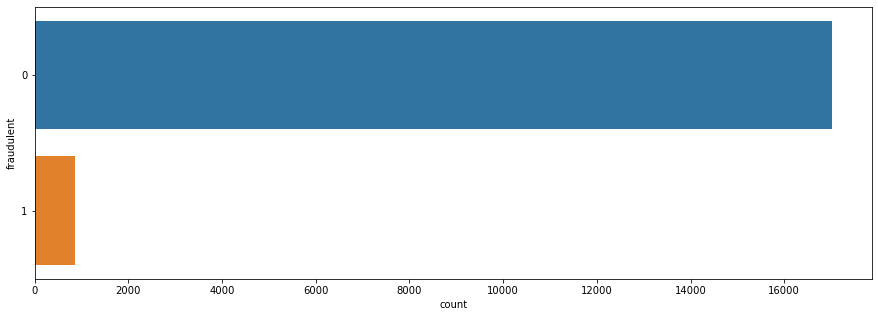

In [25]:
#compare fraudulent and non-fraudulentt

plt.figure(figsize=(15,5))
sns.countplot(y='fraudulent',data=df)
plt.show()


In [26]:
#exact count of fraud jobs

df.groupby('fraudulent')['fraudulent'].count()

fraudulent
0    17014
1      866
Name: fraudulent, dtype: int64

In [27]:
#visualization of no. of jobs posted and experienced req.

exp = dict(df.required_experience.value_counts())
del exp['']

In [28]:
exp

{'Mid-Senior level': 3809,
 'Entry level': 2697,
 'Associate': 2297,
 'Not Applicable': 1116,
 'Director': 389,
 'Internship': 381,
 'Executive': 141}

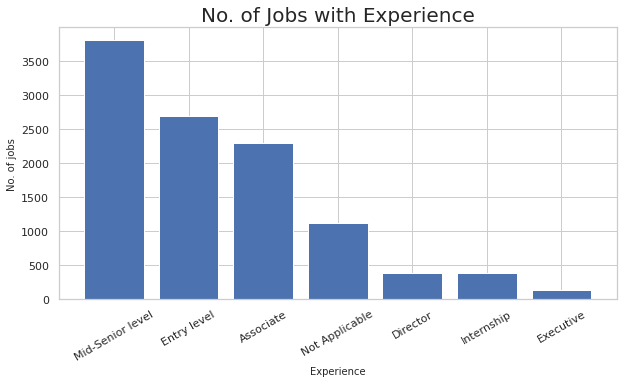

In [29]:
plt.figure(figsize=(10,5))
sns.set_theme(style="whitegrid")
plt.bar(exp.keys(), exp.values())
plt.title('No. of Jobs with Experience', size=20)
plt.xlabel('Experience', size=10)
plt.ylabel('No. of jobs', size=10)
plt.xticks(rotation=30)
plt.show()


In [30]:
#Jobs posted based on country

def split(location):
    l = location.split(',')
    return l[0]
df['country'] = df.location.apply(split)

In [31]:
df.head(50)

,title,location,department,company_profile,description,requirements,benefits,required_experience,required_education,industry,function,fraudulent,country
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,Internship,,,Marketing,0,US
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Not Applicable,,Marketing and Advertising,Customer Service,0,NZ
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,,,,,0,US
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US
4,Bill Review Manager,"US, FL, Fort Worth",,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US
5,Accounting Clerk,"US, MD,",,,Job OverviewApex is an environmental consultin...,,,,,,,0,US
6,Head of Content (m/f),"DE, BE, Berlin",ANDROIDPIT,"Founded in 2009, the Fonpit AG rose with its i...",Your Responsibilities: Manage the English-spea...,Your Know-How: ...,Your Benefits: Being part of a fast-growing co...,Mid-Senior level,Master's Degree,Online Media,Management,0,DE
7,Lead Guest Service Specialist,"US, CA, San Francisco",,Airenvy’s mission is to provide lucrative yet ...,Who is Airenvy?Hey there! We are seasoned entr...,"Experience with CRM software, live chat, and p...",Competitive Pay. You'll be able to eat steak e...,,,,,0,US
8,HP BSM SME,"US, FL, Pensacola",,Solutions3 is a woman-owned small business who...,Implementation/Configuration/Testing/Training ...,MUST BE A US CITIZEN.An active TS/SCI clearanc...,,Associate,,Information Technology and Services,,0,US
9,Customer Service Associate - Part Time,"US, AZ, Phoenix",,"Novitex Enterprise Solutions, formerly Pitney ...",The Customer Service Associate will be based i...,Minimum Requirements:Minimum of 6 months custo...,,Entry level,High School or equivalent,Financial Services,Customer Service,0,US


In [32]:
#No. of jobs posted for top 14 countries and visualize it

countr= dict(df.country.value_counts()[:14])
del countr['']
countr

{'US': 10656,
 'GB': 2384,
 'GR': 940,
 'CA': 457,
 'DE': 383,
 'NZ': 333,
 'IN': 276,
 'AU': 214,
 'PH': 132,
 'NL': 127,
 'BE': 117,
 'IE': 114,
 'SG': 80}

Text(0.5, 0, 'Countries')

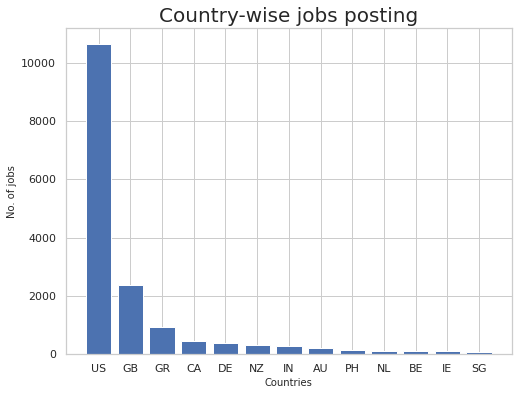

In [33]:
plt.figure(figsize=(8,6))
plt.title('Country-wise jobs posting', size=20)
plt.bar(countr.keys(), countr.values())
plt.ylabel('No. of jobs', size=10)
plt.xlabel('Countries', size=10)


In [34]:
#Visualize education level and no. of jobs posted based on it

edu = dict(df.required_education.value_counts()[:9])
del edu['']
edu

{"Bachelor's Degree": 5145,
 'High School or equivalent': 2080,
 'Unspecified': 1397,
 "Master's Degree": 416,
 'Associate Degree': 274,
 'Certification': 170,
 'Some College Coursework Completed': 102,
 'Professional': 74}

Text(0.5, 0, 'Education')

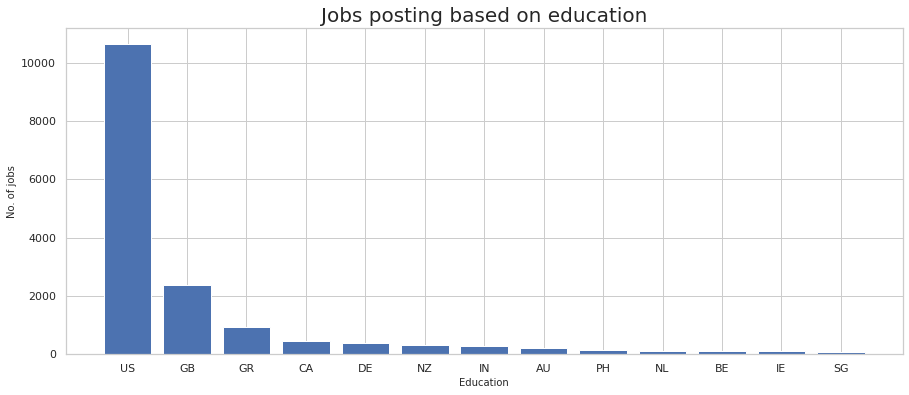

In [35]:
plt.figure(figsize=(15,6))
plt.title('Jobs posting based on education', size=20)
plt.bar(countr.keys(), countr.values())
plt.ylabel('No. of jobs', size=10)
plt.xlabel('Education', size=10)

In [36]:
#Title of Non-fraudulent Jobs posted

print(df[df.fraudulent==0].title.value_counts()[:10])

English Teacher Abroad                                311
Customer Service Associate                            146
Graduates: English Teacher Abroad (Conversational)    144
English Teacher Abroad                                 95
Software Engineer                                      86
English Teacher Abroad (Conversational)                83
Customer Service Associate - Part Time                 76
Account Manager                                        73
Web Developer                                          66
Project Manager                                        62
Name: title, dtype: int64


In [37]:
#Title of fraudulent Jobs posted

print(df[df.fraudulent==1].title.value_counts()[:10])

Home Based Payroll Typist/Data Entry Clerks Positions Available         21
Data Entry Admin/Clerical Positions - Work From Home                    21
Cruise Staff Wanted *URGENT*                                            21
Customer Service Representative                                         17
Administrative Assistant                                                16
Home Based Payroll Data Entry Clerk Position - Earn $100-$200 Daily     12
Payroll Data Coordinator Positions - Earn $100-$200 Daily               10
Network Marketing                                                       10
Payroll Clerk                                                           10
Account Sales Managers $80-$130,000/yr                                  10
Name: title, dtype: int64


In [38]:
#combine text in a single column to start cleaning our data
df['text']=df['title']+' '+df['location']+' '+df['company_profile']+' '+df['description']+' '+df['requirements']+' '+df['benefits']
del df['title']
del df['location']
del df['department']
del df['company_profile']
del df['description']
del df['requirements']
del df['benefits']
del df['required_experience']
del df['required_education']
del df['industry']
del df['function']
del df['country']

In [39]:
df.head()

,fraudulent,text
0,0,"Marketing Intern US, NY, New York We're Food52..."
1,0,"Customer Service - Cloud Video Production NZ, ..."
2,0,"Commissioning Machinery Assistant (CMA) US, IA..."
3,0,"Account Executive - Washington DC US, DC, Wash..."
4,0,"Bill Review Manager US, FL, Fort Worth SpotSou..."


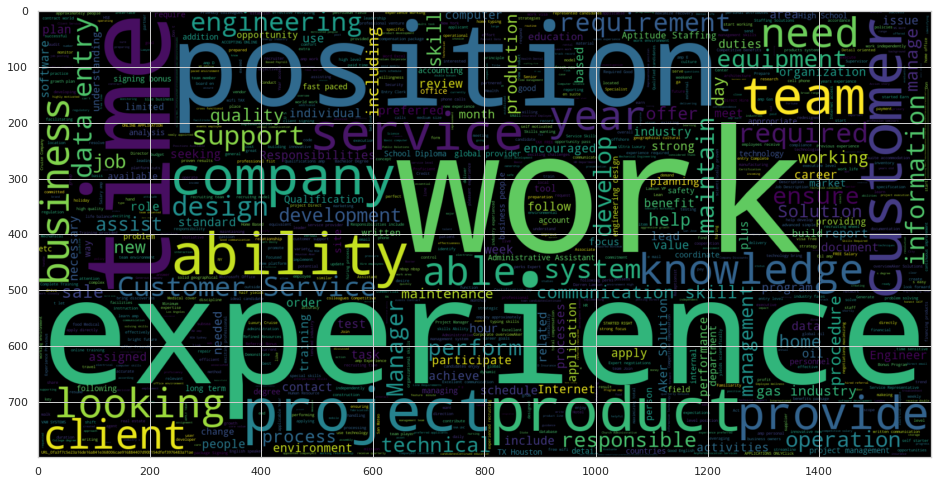

In [40]:
#Separate fraud and real jobs

fraudjobs_text = df[df.fraudulent==1].text
realjobs_text = df[df.fraudulent==0].text

#Fraudulent jobs word cloud
 
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize = (16,14))
wc = WordCloud(min_font_size =3, max_words = 3000, width = 1600, height = 800, stopwords = STOPWORDS).generate(str(" ".join(fraudjobs_text)))
plt.imshow(wc,interpolation = 'bilinear')

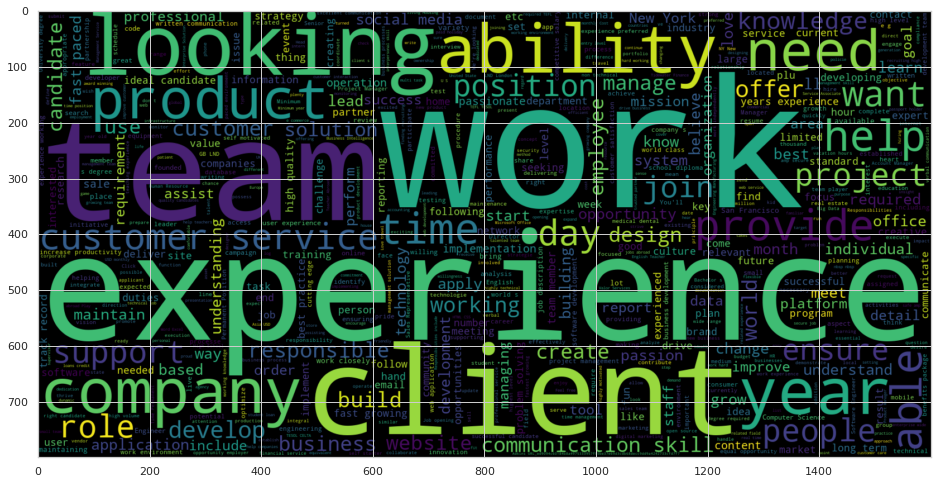

In [41]:
#Real jobs word cloud
 

plt.figure(figsize = (16,14))
wc = WordCloud(min_font_size =3, max_words = 3000, width = 1600, height = 800, stopwords = STOPWORDS).generate(str(" ".join(realjobs_text)))
plt.imshow(wc,interpolation = 'bilinear')

In [42]:
# to work with eng words and NLP we need to install some more packages

!pip install spacy && python -m spacy download en

You should consider upgrading via the '/home/oem/anaconda3/bin/python -m pip install --upgrade pip' command.
2022-04-12 12:58:49.080837: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-12 12:58:49.080864: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     |████████████████████████████████| 13.9 MB 328 kB/s            


You should consider upgrading via the '/home/oem/anaconda3/bin/python -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [43]:
#Cleaning and preprocessing
#Cleaning our list of punctuation marks 

punctuations = string.punctuation

#Create list of stopwords

nlp = spacy.load("en_core_web_sm")
stop_words = spacy.lang.en.stop_words.STOP_WORDS

#Load eng tokenizers, parsers, taggers, NER and word vectors

parser = English()

#Creating tokenizer function

def spacy_tokenizer(sentence):
    
    #Creating token object, which is to create documents with Linguistic annotations
    mytokens = parser(sentence)
    
    #Lemmatizing each token and converting each token into lowercase 
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_  for word in mytokens ]
    
    #Removing stops words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    
    #Return a preprocessed list of tokens
    return mytokens

#Custom transformer using spacy
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        #Cleaning texts
        return [clean_text(text) for text in X]
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def get_params(self, deep=True):
        return{}
    
#Basic functions to clean the text
def clean_text(text):
    #Removing spaces and converting text into lowercase
    return text.strip().lower()

In [44]:
#Cleaning the text of dataset

df['text'] = df['text'].apply(clean_text)

In [45]:
#TFIDF vectorizer 

cv = TfidfVectorizer(max_features = 100)
x = cv.fit_transform(df['text'])
df1 = pd.DataFrame(x.toarray(), columns=cv.get_feature_names())
df.drop(["text"], axis=1, inplace=True)
main_df = pd.concat([df1,df], axis=1)

In [46]:
main_df.head()

,ability,about,all,also,amp,an,and,are,as,at,...,who,will,with,work,working,world,years,you,your,fraudulent
0,0.000000,0.040922,0.000000,0.042219,0.036312,0.000000,0.751597,0.000000,0.078274,0.000000,...,0.00000,0.000000,0.185171,0.050739,0.067701,0.000000,0.000000,0.000000,0.000000,0
1,0.021899,0.094202,0.035399,0.024297,0.041796,0.029777,0.490997,0.056638,0.060062,0.052432,...,0.00000,0.078020,0.165769,0.043800,0.116886,0.099347,0.000000,0.204896,0.130479,0
2,0.000000,0.000000,0.176735,0.000000,0.041735,0.089200,0.396893,0.113110,0.000000,0.000000,...,0.00000,0.062325,0.307407,0.058315,0.000000,0.000000,0.000000,0.094429,0.074450,0
3,0.023265,0.000000,0.018803,0.000000,0.000000,0.094900,0.695482,0.000000,0.031904,0.037134,...,0.02313,0.049731,0.075474,0.046531,0.000000,0.105542,0.019805,0.050232,0.059406,0
4,0.000000,0.000000,0.067990,0.000000,0.040138,0.028596,0.606245,0.081587,0.115360,0.000000,...,0.00000,0.000000,0.159195,0.028042,0.037417,0.000000,0.035806,0.030272,0.107403,0


In [47]:
#Split dataset  into test and train

Y = main_df.iloc[:,-1]
X = main_df.iloc[:,:-1]

X_train, X_test, y_train, y_test = train_test_split(x,Y, test_size=0.3)

#Shape of data that has been split into 4 prts
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(12516, 100)
(12516,)
(5364, 100)
(5364,)


In [48]:
#RandomForest Algo to train the model

from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_jobs=3,oob_score=True,n_estimators=100,criterion="entropy")
model=rfc.fit(X_train,y_train)

In [49]:
print(X_test)

  (0, 23)	0.258672518614117
  (0, 62)	0.04245516767122657
  (0, 77)	0.04318245011345663
  (0, 67)	0.03645936501758356
  (0, 57)	0.0332134785284808
  (0, 34)	0.03416428406196199
  (0, 48)	0.12078915482163183
  (0, 74)	0.0377528750204691
  (0, 64)	0.03691706687875591
  (0, 16)	0.0681292957850346
  (0, 27)	0.07018989405238767
  (0, 82)	0.08479217150592067
  (0, 72)	0.04118395402522309
  (0, 18)	0.03885608507616974
  (0, 11)	0.13922353601940302
  (0, 92)	0.04976641656549166
  (0, 10)	0.034609437411172506
  (0, 79)	0.02454838867643102
  (0, 17)	0.1272819655900528
  (0, 58)	0.06566614228200639
  (0, 61)	0.08209467888224498
  (0, 41)	0.030640783595540958
  (0, 7)	0.06773906785107073
  (0, 71)	0.05573740801566749
  (0, 98)	0.10053605583075674
  :	:
  (5363, 56)	0.043885616965841284
  (5363, 51)	0.20081397607693285
  (5363, 94)	0.0750670161204647
  (5363, 84)	0.018954843604313973
  (5363, 40)	0.053651453556158184
  (5363, 15)	0.03857459531588641
  (5363, 12)	0.02536631024675301
  (5363, 93)	0.0

In [50]:
#Model is trained, now predection

pred = rfc.predict(X_test)
score = accuracy_score(y_test,pred)
score

0.9716629381058911

Classification Report

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      5106
           1       0.98      0.42      0.59       258

    accuracy                           0.97      5364
   macro avg       0.98      0.71      0.79      5364
weighted avg       0.97      0.97      0.97      5364

Confusion Matrix

[[5104    2]
 [ 150  108]]


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

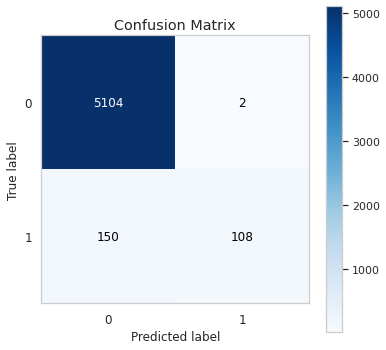

In [51]:
#Classification Report and along with that create confusion matrix to understand the model accuracy

print("Classification Report\n")
print(classification_report(y_test, pred))
print("Confusion Matrix\n")
print(confusion_matrix(y_test, pred))
skplt.metrics.plot_confusion_matrix(y_test, pred, figsize=(6,6))
